## SKYFAST: Tutorial

This tutorial demonstrates how to use SKYFAST (Demasi et al., in preparation), a Python code designed for the rapid localization of gravitational wave hosts. 

SKYFAST takes posterior samples produced by a parameter estimation pipeline as input and uses them to reconstruct an analytic joint posterior for right ascension, declination, luminosity distance, and, optionally, the inclination angle of the GW event. The posterior reconstruction is performed using a Dirichlet Process Gaussian Mixture Model (DPGMM), a Bayesian non-parametric method. 

SKYFAST is based on the DPGMM implementation in FIGARO by Rinaldi & Del Pozzo, 2022 (https://arxiv.org/abs/2205.07252).




### Installation

We recomment to create a conda environment with Python 3.11:

`conda create --name skyfast_env python==3.11`.


Then activate it:

`conda activate skyfast_env`


Lastly, download SKYFAST from git and install it:

`git clone git@github.com:gabrieledemasi/skyfast.git`

`cd skyfast`

`pip install .`




### Load the GLADE+ galaxy catalog

At the moment, SKYFAST looks for the most probable galaxy hosts within the GLADE+ catalog (Dálya et al. 2022, https://arxiv.org/abs/2110.06184). However, the pipeline can be easily adapted to any catalog.

Download the "GLADE+.txt' file from http://glade.elte.hu/ (should be around 6 GB)
 
Preprocess it running 

`make_glade -i "/path_to_the_glade_file_position/GLADE+.txt"` 

This command creates in the same folder a lighter glade+.hdf5 file, that can be passed to SKYFAST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from skyfast.skyfast import skyfast
from figaro.utils import get_priors
import h5py
from tqdm import tqdm

glade_file = '/path_to_the_glade_file_position/glade+.hdf5' #raplace this with the correct path!!

### Load the posterior samples

In this tutorial, we take GW170817 as a working example. We will use the posterior samples from Finstad et al. 2018 (https://arxiv.org/abs/1804.04179), publicly available at https://github.com/sugwg/gw170817-inclination-angle. 

In principle, SKYFAST can use the posterior samples produced by any PE pipeline, as long as they are arranged as an array with as many rows as the number of samples and either 3 or 4 columns, depending on whether we are including the inclination angle or not. Angles must be expressed in radians, luminosity distance in Mpc.


In [2]:
#load samples from the .hdf5 file
with h5py.File('data/gw_only_posteriors.hdf', 'r') as file:
    ra = np.array(file['samples']['ra'])
    dec = np.array(file['samples']['dec'])
    d_L = np.array(file['samples']['distance'])
    theta_jn = np.array(file['samples']['inclination']) 

#arrange them in a format suitable for SKYFAST 
samples = np.array([ra, dec, d_L, theta_jn]).T

#The file contains a lot of samples, so we take only one third of them for the sake of time
samples = samples[::3]
np.random.shuffle(samples)


### Priors for the DPGMM

We will use of some of the available samples (we found that 200 is a good number) to set reasonable priors for the mean and variance of each Gaussian component in the mixture. We use the figaro.utils method `get_priors`. 

We have to make sure that we define a parameter space that contains all the samples that we are going to pass to SKYFAST. The bounds for the angles is always well defined, while we have to be more careful for the luminosity distance. We found that a good solution is to set the luminosity distance bound to 1.5 times the maximum distance of the 200 samples that we pass to `get_priors`.

In [3]:
max_dist = np.max(np.array(samples[:200])[:,2])*1.5
bounds = np.array([[0., 2*np.pi], [-np.pi/2, np.pi/2], [0., max_dist], [0, np.pi]])
prior_pars = get_priors(bounds = bounds, samples = samples[:200], probit = True, scale=1)

### Initialize SKYFAST 

We are now ready to initialize an instance of SKYFAST, which we will use to reconstruct the position and inclination angle posteriors for GW170817. It should take only a bunch of seconds. 

In [4]:
dens = skyfast(max_dist,                                   #maximum distance for the grid
                glade_file=glade_file,                     #path to glade+.hdf5 file created before
                prior_pars= prior_pars,                    #priors for the DPGMM
                n_gridpoints=[800, 400, 100],              #points in the 3D coordinate grid (ra, dec, dL)
                inclination = True,                        #we want to include the inclination angle in the reconstruction
                true_host=[3.44613, -0.40812, 41.00982],   #position of NGC 4993, the true host of GW170817
                true_inclination = [2.5831],               #GW170817 inclunation angle, as reported in Finstad+18     
                entropy = True,                            #we compute the information entropy each time a sample is added to the mixture
                out_name = 'gw170817_test0',               #name of the output from the current analysis
                out_folder= './results_tutorial',          #path to the output folder
                theta_condition = True                     #we want to compute the inclination angle posterior conditioned to the position of each potential galaxy host  
                )

### Posterior reconstruction 

Now, we use `intermediate_skymap` to pass the samples one by one to SKYFAST.

Since we set `entropy = True`, SKYFAST computes the information entropy of the reconstructed posterior each time a sample is added to the DPGMM mixture.

When the information entropy reaches a plateau, adding further samples does not provide much additional information. This convergence criterion is usually met using a only fraction of the samples produced by the PE, resulting in considerable time savings when SKYFAST is run online alongside the PE pipeline.

After convergence is reached, the intermediate posterior reconstruction, along with the related skymap, volume map, and list of the most probable galaxy hosts, are released and saved in the output directory, marked as 'intermediate'.

It is possible to visualize the plots using show = True; otherwise, they will be saved without displaying.

  8%|▊         | 387/5148 [00:05<00:17, 273.13it/s]

INTERMEDIATE RECONSTRUCTION


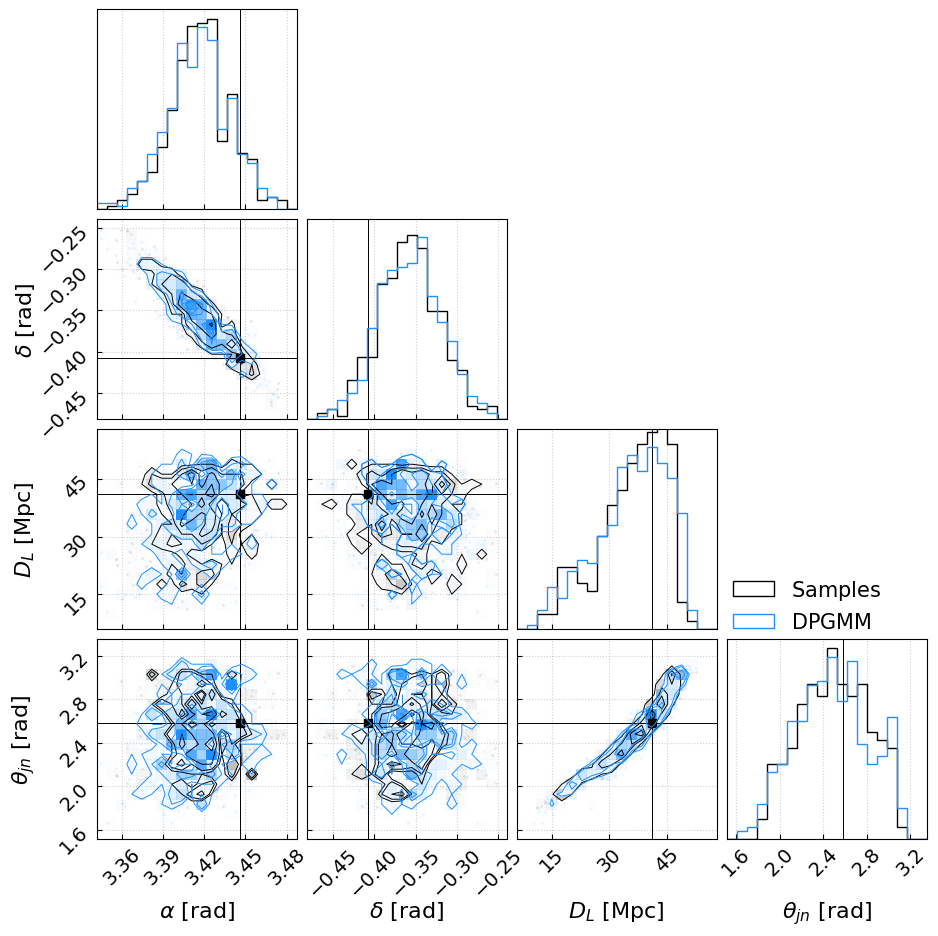

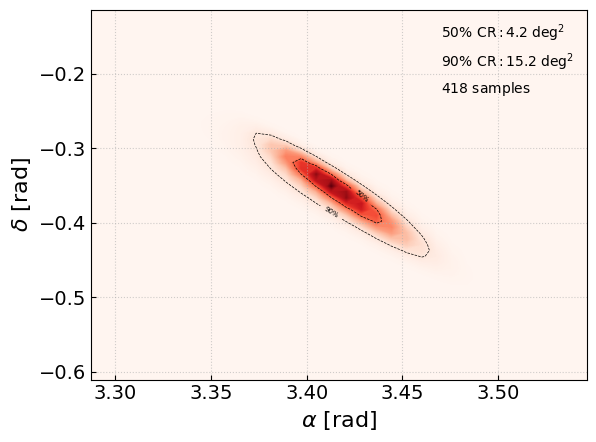

  8%|▊         | 387/5148 [00:20<00:17, 273.13it/s]

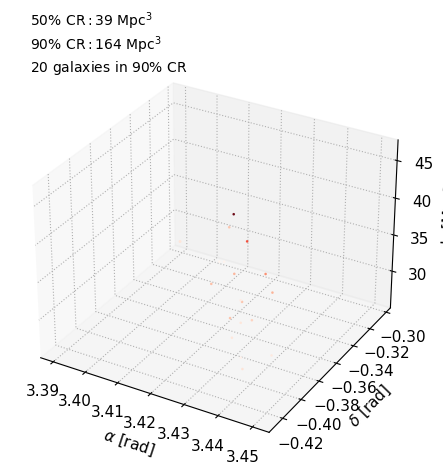

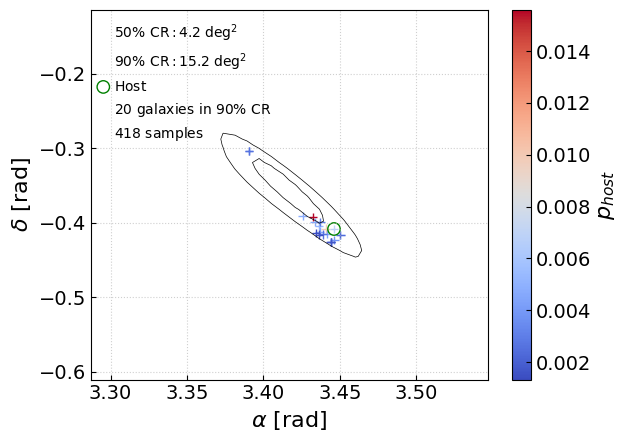

100%|██████████| 5148/5148 [00:44<00:00, 115.76it/s]


In [5]:
for i in tqdm(range(len(samples))):
        dens.intermediate_skymap(samples[i], show = True)

Now that also the reconstruction using all the samples is finished, we can plot the entropy as a function of the number of samples in the misture. 

We can also produce a corner plot of the posterior reconstructed posterior, its related skymap and volume map, to be compared with the intermediate ones. 

As a final step, we save a log file with all the key information of the current SKYFAST run.  

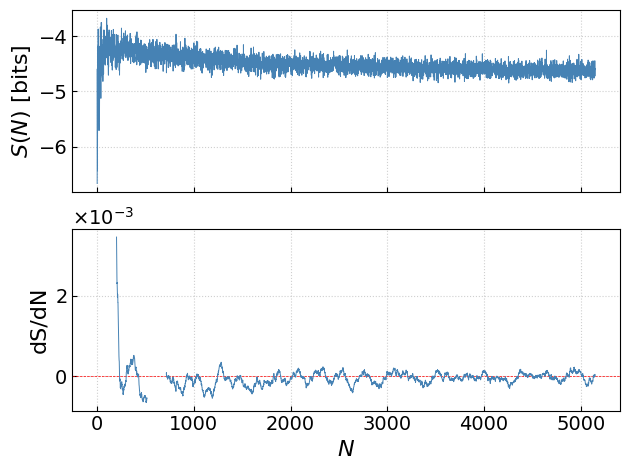

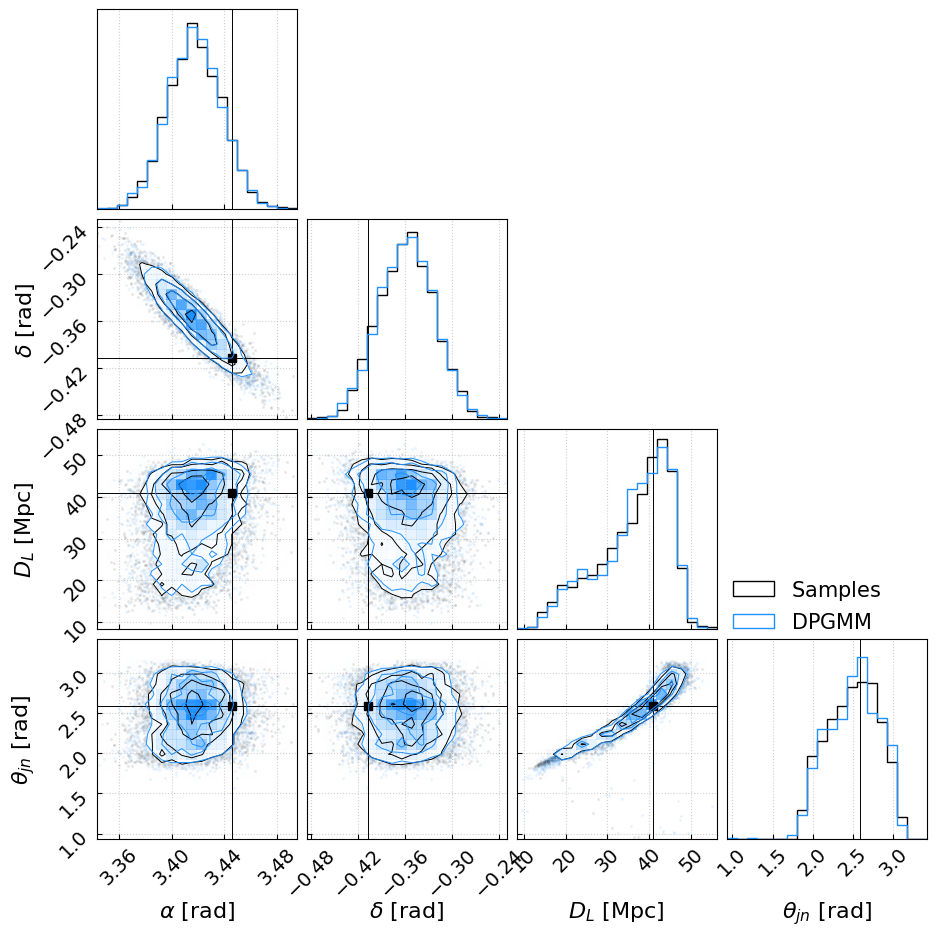

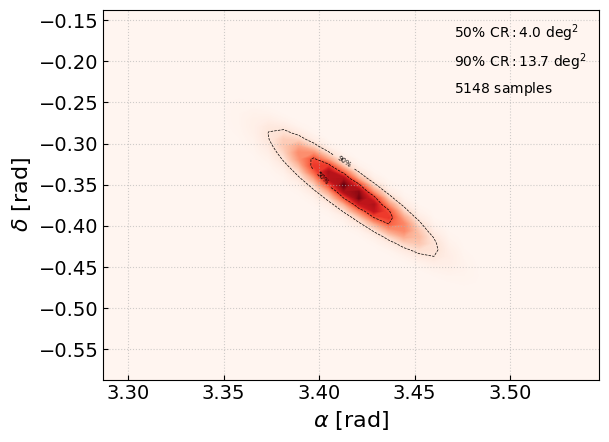

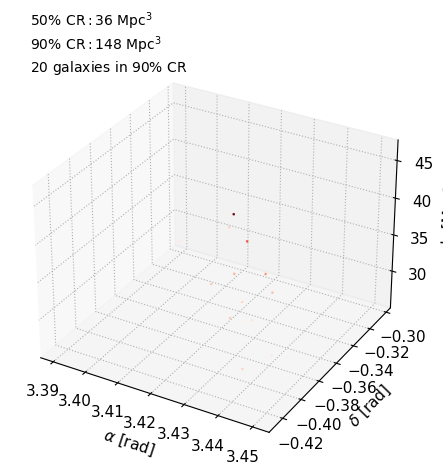

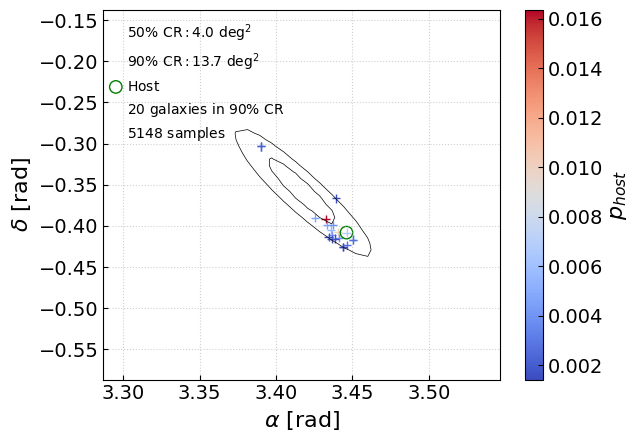

In [6]:
# Entropy plot
dens.make_entropy_plot(show = True) 

# Reconstructed posterior, skymap and volume map obtained with all the PE samples
dens.save_density(final_map = True)
dens.plot_samples(samples, final_map = True, show = True)
dens.make_skymap(final_map = True, show = True)
dens.make_volume_map(final_map = True,  show = True)

# Save log file
dens.save_log() 

## Recap of SKYFAST outputs

List of created directories and outputs. If `entropy = True`, the outputs are produced both for the intermediate and the final posterior reconsturction.

* CORNER: comparison of the original PE samples with samples from the reconstructed posterior
* DENSITY: file .json with the gaussian mixture
* ENTROPY: entropy plot
* HOSTS: list of galaxies within the 90% volume with or without the information about the inclination angle posterior conditioned to the position of each galaxies. 
* LOG: log file 
* SKYMAPS: skymap with credible regions and skymap with galaxies in the 90% credible volume
* VOLUME: volume map
